# Setup

In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [4]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '..')

In [6]:
import json
import glob
from utils.metrics import extract_metrics_config, Metric

In [7]:
file_list = glob.glob('./experiments/configs/*amazon*.json')

configs = [json.load(open(file)) for file in file_list]

In [8]:
# add prefix to path

for config in configs:
    config["model"]["training"][
        "log_dir"] = "experiments/" + config["model"]["training"]["log_dir"]

# Load metrics

In [9]:
metrics = [Metric(**extract_metrics_config(config)) for config in configs]

# ROC Curve

[[<matplotlib.lines.Line2D at 0x152f8ab4b6a0>],

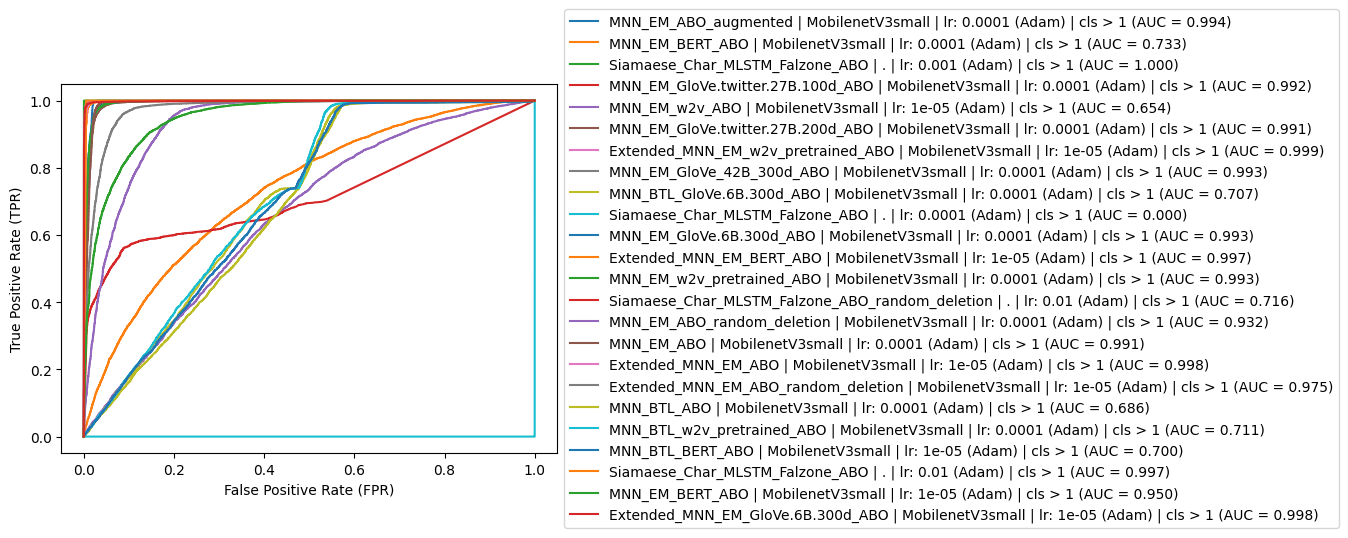

In [10]:
[metric.plot_roc() for metric in metrics]

# Precision-Recall Curve (PRC)

[[<matplotlib.lines.Line2D at 0x152f881c6070>],

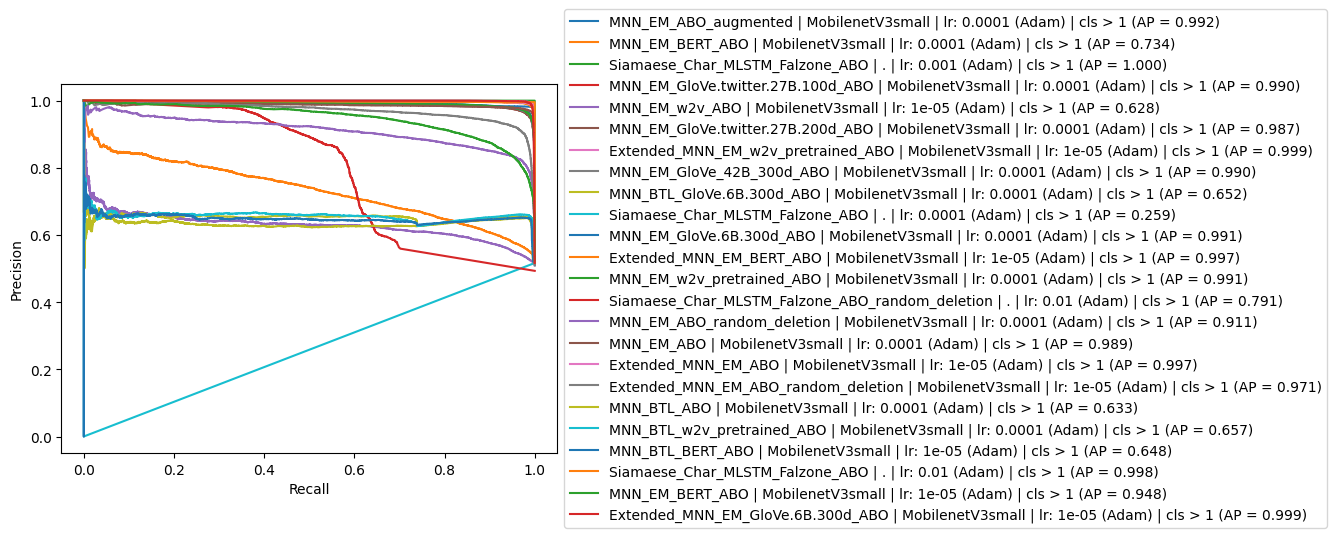

In [11]:
[metric.plot_prc() for metric in metrics]

# Optimal accuracy

The `optimize_threshold()` method calculates and outputs optimal threshold for ROC curve using G-Mean and Youden-Index/J, as well as the optimal threshold for Precision-Recall curve using F-Score.

See also https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [12]:
import pandas as pd

In [14]:
metrics_df = pd.DataFrame.from_dict(
    [metric.optimize_threshold() for metric in metrics])

# select metrics relevant for paper
metrics_df = metrics_df[["Model name", "Image CNN", "lr", "AUC-ROC", "AUC-PRC", "Precision", "Recall", "F-Score", "Threshold F-Score", "Accuracy F-Score"]]
metrics_df[["AUC-ROC", "AUC-PRC", "Precision", "Recall", "F-Score", "Threshold F-Score"]] = metrics_df[["AUC-ROC", "AUC-PRC", "Precision", "Recall", "F-Score", "Threshold F-Score"]].round(4)
metrics_df["Accuracy F-Score"] = metrics_df["Accuracy F-Score"] * 100
metrics_df["Accuracy F-Score"] = metrics_df["Accuracy F-Score"].round(2)
metrics_df["Accuracy F-Score"] = metrics_df["Accuracy F-Score"].astype(str)
metrics_df["Accuracy F-Score"] = metrics_df["Accuracy F-Score"] + " %"

# All models ranked by Accuracy

In [15]:
metrics_df.sort_values(by="Accuracy F-Score", ascending=False)

,Model name,Image CNN,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
6,Extended_MNN_EM_w2v_pretrained_ABO,MobilenetV3small,0.00001,0.9991,0.9994,0.9911,0.9954,0.9932,0.7268,99.27 %
23,Extended_MNN_EM_GloVe.6B.300d_ABO,MobilenetV3small,0.00001,0.9983,0.9987,0.9925,0.9900,0.9912,0.7815,99.09 %
16,Extended_MNN_EM_ABO,MobilenetV3small,0.00001,0.9977,0.9974,0.9882,0.9931,0.9907,0.8710,99.02 %
11,Extended_MNN_EM_BERT_ABO,MobilenetV3small,0.00001,0.9969,0.9966,0.9861,0.9897,0.9879,0.7107,98.73 %
0,MNN_EM_ABO_augmented,MobilenetV3small,0.00010,0.9939,0.9923,0.9791,0.9966,0.9878,0.4782,98.71 %
15,MNN_EM_ABO,MobilenetV3small,0.00010,0.9914,0.9887,0.9691,0.9901,0.9795,0.2747,97.85 %
10,MNN_EM_GloVe.6B.300d_ABO,MobilenetV3small,0.00010,0.9930,0.9910,0.9681,0.9837,0.9759,0.6062,97.48 %
7,MNN_EM_GloVe_42B_300d_ABO,MobilenetV3small,0.00010,0.9928,0.9900,0.9634,0.9850,0.9741,0.4712,97.29 %
12,MNN_EM_w2v_pretrained_ABO,MobilenetV3small,0.00010,0.9931,0.9910,0.9646,0.9835,0.9739,0.6684,97.26 %
3,MNN_EM_GloVe.twitter.27B.100d_ABO,MobilenetV3small,0.00010,0.9925,0.9903,0.9634,0.9818,0.9725,0.3821,97.13 %


# MNN-EM

In [16]:
metrics_df[metrics_df["Model name"].str.startswith("MNN_EM")].sort_values(by="Accuracy F-Score", ascending=False)

,Model name,Image CNN,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
0,MNN_EM_ABO_augmented,MobilenetV3small,0.00010,0.9939,0.9923,0.9791,0.9966,0.9878,0.4782,98.71 %
15,MNN_EM_ABO,MobilenetV3small,0.00010,0.9914,0.9887,0.9691,0.9901,0.9795,0.2747,97.85 %
10,MNN_EM_GloVe.6B.300d_ABO,MobilenetV3small,0.00010,0.9930,0.9910,0.9681,0.9837,0.9759,0.6062,97.48 %
7,MNN_EM_GloVe_42B_300d_ABO,MobilenetV3small,0.00010,0.9928,0.9900,0.9634,0.9850,0.9741,0.4712,97.29 %
12,MNN_EM_w2v_pretrained_ABO,MobilenetV3small,0.00010,0.9931,0.9910,0.9646,0.9835,0.9739,0.6684,97.26 %
3,MNN_EM_GloVe.twitter.27B.100d_ABO,MobilenetV3small,0.00010,0.9925,0.9903,0.9634,0.9818,0.9725,0.3821,97.13 %
5,MNN_EM_GloVe.twitter.27B.200d_ABO,MobilenetV3small,0.00010,0.9909,0.9868,0.9647,0.9773,0.9710,0.6109,96.97 %
14,MNN_EM_ABO_random_deletion,MobilenetV3small,0.00010,0.9320,0.9113,0.8247,0.9685,0.8909,0.2817,87.9 %
22,MNN_EM_BERT_ABO,MobilenetV3small,0.00001,0.9498,0.9479,0.8477,0.9374,0.8903,0.0645,87.88 %
1,MNN_EM_BERT_ABO,MobilenetV3small,0.00010,0.7334,0.7341,0.6139,0.8881,0.7260,0.0000,64.83 %


# Extended MNN-EM

In [17]:
metrics_df[metrics_df["Model name"].str.startswith("Extended_MNN_EM")].sort_values(by="Accuracy F-Score", ascending=False)

,Model name,Image CNN,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
6,Extended_MNN_EM_w2v_pretrained_ABO,MobilenetV3small,0.00001,0.9991,0.9994,0.9911,0.9954,0.9932,0.7268,99.27 %
23,Extended_MNN_EM_GloVe.6B.300d_ABO,MobilenetV3small,0.00001,0.9983,0.9987,0.9925,0.9900,0.9912,0.7815,99.09 %
16,Extended_MNN_EM_ABO,MobilenetV3small,0.00001,0.9977,0.9974,0.9882,0.9931,0.9907,0.8710,99.02 %
11,Extended_MNN_EM_BERT_ABO,MobilenetV3small,0.00001,0.9969,0.9966,0.9861,0.9897,0.9879,0.7107,98.73 %
17,Extended_MNN_EM_ABO_random_deletion,MobilenetV3small,0.00001,0.9751,0.9707,0.9170,0.9632,0.9395,0.6147,93.68 %


# MNN-BTL

In [18]:
metrics_df[metrics_df["Model name"].str.startswith("MNN_BTL")].sort_values(by="Accuracy F-Score", ascending=False)

,Model name,Image CNN,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
19,MNN_BTL_w2v_pretrained_ABO,MobilenetV3small,0.00010,0.7113,0.6565,0.6584,0.9873,0.7900,-0.2802,72.73 %
8,MNN_BTL_GloVe.6B.300d_ABO,MobilenetV3small,0.00010,0.7068,0.6525,0.6531,0.9824,0.7846,-0.3797,71.96 %
18,MNN_BTL_ABO,MobilenetV3small,0.00010,0.6862,0.6330,0.6507,0.9942,0.7866,-0.4823,71.96 %
20,MNN_BTL_BERT_ABO,MobilenetV3small,0.00001,0.7001,0.6481,0.6494,0.9882,0.7837,-0.4104,71.67 %


# Siamese Char-level MLSTM

In [19]:
metrics_df[metrics_df["Model name"].str.startswith("Siamaese")].sort_values(by="Accuracy F-Score", ascending=False)

,Model name,Image CNN,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
13,Siamaese_Char_MLSTM_Falzone_ABO_random_deletion,.,0.0100,0.7157,0.7914,0.8397,0.5741,0.6819,0.3819,73.58 %
21,Siamaese_Char_MLSTM_Falzone_ABO,.,0.0100,0.9975,0.9977,0.9953,1.0000,0.9976,0.9972,48.26 %
2,Siamaese_Char_MLSTM_Falzone_ABO,.,0.0010,0.9999,0.9999,0.9998,1.0000,0.9999,1.0000,48.08 %
9,Siamaese_Char_MLSTM_Falzone_ABO,.,0.0001,0.0001,0.2586,0.5166,1.0000,0.6813,0.1823,0.07 %


# Word2Vec (all models)

In [20]:
metrics_df[metrics_df["Model name"].str.contains("w2v")].sort_values(by="Accuracy F-Score", ascending=False)

,Model name,Image CNN,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
6,Extended_MNN_EM_w2v_pretrained_ABO,MobilenetV3small,0.00001,0.9991,0.9994,0.9911,0.9954,0.9932,0.7268,99.27 %
12,MNN_EM_w2v_pretrained_ABO,MobilenetV3small,0.00010,0.9931,0.9910,0.9646,0.9835,0.9739,0.6684,97.26 %
19,MNN_BTL_w2v_pretrained_ABO,MobilenetV3small,0.00010,0.7113,0.6565,0.6584,0.9873,0.7900,-0.2802,72.73 %
4,MNN_EM_w2v_ABO,MobilenetV3small,0.00001,0.6540,0.6284,0.5676,0.9255,0.7037,0.0314,59.87 %


# GloVe (all models)

In [21]:
metrics_df[metrics_df["Model name"].str.contains("GloVe")].sort_values(by="Accuracy F-Score", ascending=False)

,Model name,Image CNN,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
23,Extended_MNN_EM_GloVe.6B.300d_ABO,MobilenetV3small,0.00001,0.9983,0.9987,0.9925,0.9900,0.9912,0.7815,99.09 %
10,MNN_EM_GloVe.6B.300d_ABO,MobilenetV3small,0.00010,0.9930,0.9910,0.9681,0.9837,0.9759,0.6062,97.48 %
7,MNN_EM_GloVe_42B_300d_ABO,MobilenetV3small,0.00010,0.9928,0.9900,0.9634,0.9850,0.9741,0.4712,97.29 %
3,MNN_EM_GloVe.twitter.27B.100d_ABO,MobilenetV3small,0.00010,0.9925,0.9903,0.9634,0.9818,0.9725,0.3821,97.13 %
5,MNN_EM_GloVe.twitter.27B.200d_ABO,MobilenetV3small,0.00010,0.9909,0.9868,0.9647,0.9773,0.9710,0.6109,96.97 %
8,MNN_BTL_GloVe.6B.300d_ABO,MobilenetV3small,0.00010,0.7068,0.6525,0.6531,0.9824,0.7846,-0.3797,71.96 %


# BERT (all models)

In [22]:
metrics_df[metrics_df["Model name"].str.contains("BERT")].sort_values(by="Accuracy F-Score", ascending=False)

,Model name,Image CNN,lr,AUC-ROC,AUC-PRC,Precision,Recall,F-Score,Threshold F-Score,Accuracy F-Score
11,Extended_MNN_EM_BERT_ABO,MobilenetV3small,0.00001,0.9969,0.9966,0.9861,0.9897,0.9879,0.7107,98.73 %
22,MNN_EM_BERT_ABO,MobilenetV3small,0.00001,0.9498,0.9479,0.8477,0.9374,0.8903,0.0645,87.88 %
20,MNN_BTL_BERT_ABO,MobilenetV3small,0.00001,0.7001,0.6481,0.6494,0.9882,0.7837,-0.4104,71.67 %
1,MNN_EM_BERT_ABO,MobilenetV3small,0.00010,0.7334,0.7341,0.6139,0.8881,0.7260,0.0000,64.83 %
